# W7_Logistic Regression via Stochastic Gradient Ascent

In [1]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('amazon_baby_subset.csv')
data = data.fillna(value={'review':''}) # replace all NaN elements in column ‘review’ with ''

# perform text cleaning
def remove_punctuation(text):
    table = str.maketrans(dict.fromkeys(string.punctuation))
    return text.translate(table)

data['cleaned_review'] = data['review'].apply(remove_punctuation)

data.head()

,name,review,rating,sentiment,cleaned_review
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago S...
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,One of babys first and favorite books and it i...
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,Very cute interactive book My son loves this b...


In [3]:
important_words = list(pd.read_json('important_words.json')[0])
len(important_words)

193

In [4]:
for word in important_words:
    data[word] = data['cleaned_review'].apply(lambda s : s.split().count(word))

In [5]:
data.head(1)

,name,review,rating,sentiment,cleaned_review,baby,one,great,love,use,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train_index = list(pd.read_json('module-10-assignment-train-idx.json')[0])
val_index = list(pd.read_json('module-10-assignment-validation-idx.json')[0])
train = data.iloc[train_index]
validation = data.iloc[val_index]

In [7]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    feature_matrix = dataframe[features].values
    label_array = dataframe[label].values
    return(feature_matrix, label_array)

In [8]:
train_X, train_y = get_numpy_data(train, important_words, 'sentiment')
val_X, val_y = get_numpy_data(validation, important_words, 'sentiment')

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
def predict_probability(feature_matrix, coefficients):
    score = np.dot(feature_matrix, coefficients)
    prob_predictions = 1 / (1 + np.exp(-score))
    return prob_predictions

In [10]:
def feature_derivative(errors, feature):    
    derivative = np.dot(errors, feature)
    return derivative

In [11]:
def compute_avg_log_likelihood(feature_matrix, label_array, coefficients):
    indicator = (label_array==1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]   
    
    lp = np.sum((indicator-1)*scores - logexp)/len(feature_matrix)   
    # 1/N term makes it easier to compare stochastic gradient ascent with batch gradient ascent
    return lp

In [12]:
def logistic_regression_SG(feature_matrix, label_array, initial_coefficients, step_size, batch_size, max_iter):
    log_likelihood_all = [] # for plotting purpose
    coefficients = initial_coefficients
    
    # set seed=1 to produce consistent results
    np.random.seed(seed=1)
    # shuffle the data 
    permutation = np.random.permutation(len(feature_matrix))
    feature_matrix = feature_matrix[permutation,:]
    label_array = label_array[permutation]

    i = 0 # index of current batch
    for itr in range(max_iter):
        predictions = predict_probability(feature_matrix[i:i+batch_size,:], coefficients)
        indicator = (label_array[i:i+batch_size]==1)
        errors = indicator - predictions
        
        for j in range(len(coefficients)): 
            derivative = feature_derivative(errors, feature_matrix[i:i+batch_size,j])
            coefficients[j] +=  step_size * derivative * (1/batch_size) # normalization


        lp = compute_avg_log_likelihood(feature_matrix[i:i+batch_size,:], label_array[i:i+batch_size], coefficients)
        log_likelihood_all.append(lp)
        
        #if (itr<=15) or (itr<=1000 and itr%100==0) or (itr<=10000 and itr%1000==0) or (itr%10000==0) or (itr==max_iter-1):
        #    print('iteration {}: {}'.format(itr, lp))

        i += batch_size
        
        # if making a complete pass over data, shuffle and restart
        if i+batch_size > len(feature_matrix):
            permutation = np.random.permutation(len(feature_matrix))
            feature_matrix = feature_matrix[permutation,:]
            label_array = label_array[permutation]
            i = 0                
    
    return coefficients, log_likelihood_all

In [13]:
# stochastic gradient ascent (batch_size=1)
coef_1, loglikehood_1 = logistic_regression_SG(train_X, train_y, np.zeros(194), 5e-1, 1, 10)

In [14]:
def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    moving_avg = np.convolve(np.array(log_likelihood_all), np.ones(smoothing_window)/smoothing_window, mode='valid')
    
    x = np.array(range(smoothing_window-1, len(log_likelihood_all))) * float(batch_size) / len_data # compute the pass
    y = moving_avg
    
    plt.plot(x, y, linewidth=1.5, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})

In [15]:
# stochastic gradient ascent vs batch gradient ascent
# num of passes = 200
# stochastic gradient (batch_size=100)
coef_2, loglikehood_2 = logistic_regression_SG(train_X, train_y, np.zeros(194), 1e-1, 100, int(200*len(train_X)/100))

In [16]:
# batch gradient (batch_size=num of training points)
coef_3, loglikehood_3 = logistic_regression_SG(train_X, train_y, np.zeros(194), 5e-1, len(train_X), 200)

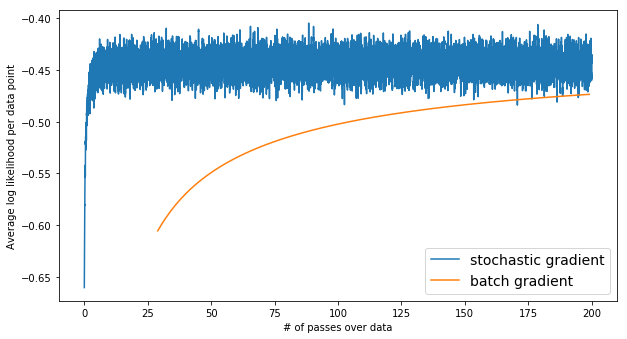

In [17]:
# stochastic gradient (batch_size=100)
make_plot(loglikehood_2, len(train_X), 100, 30, label='stochastic gradient')
# batch gradient (batch_size=num of training points)
make_plot(loglikehood_3, len(train_X), len(train_X), 30, label='batch gradient')

In [18]:
# explore the effects of step sizes on stochastic gradient ascent
coef__1, loglikehood__1 = logistic_regression_SG(train_X, train_y, np.zeros(194), 1e-4, 100, int(10*len(train_X)/100))
coef__2, loglikehood__2 = logistic_regression_SG(train_X, train_y, np.zeros(194), 1e-3, 100, int(10*len(train_X)/100))
coef__3, loglikehood__3 = logistic_regression_SG(train_X, train_y, np.zeros(194), 1e-2, 100, int(10*len(train_X)/100))
coef__4, loglikehood__4 = logistic_regression_SG(train_X, train_y, np.zeros(194), 1e-1, 100, int(10*len(train_X)/100))
coef__5, loglikehood__5 = logistic_regression_SG(train_X, train_y, np.zeros(194), 1e0, 100, int(10*len(train_X)/100))
coef__6, loglikehood__6 = logistic_regression_SG(train_X, train_y, np.zeros(194), 1e1, 100, int(10*len(train_X)/100))
coef__7, loglikehood__7 = logistic_regression_SG(train_X, train_y, np.zeros(194), 1e2, 100, int(10*len(train_X)/100))

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


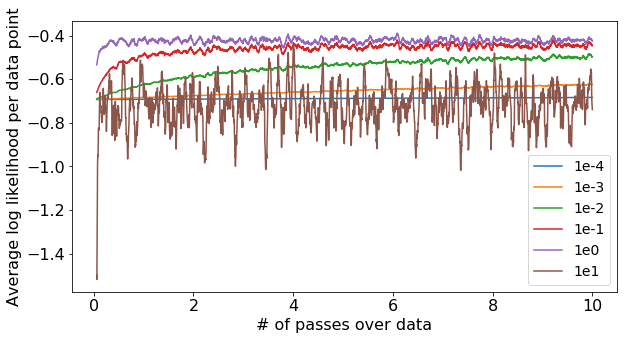

In [19]:
make_plot(loglikehood__1, len(train_X), 100, 30, label='1e-4')
make_plot(loglikehood__2, len(train_X), 100, 30, label='1e-3')
make_plot(loglikehood__3, len(train_X), 100, 30, label='1e-2')
make_plot(loglikehood__4, len(train_X), 100, 30, label='1e-1')
make_plot(loglikehood__5, len(train_X), 100, 30, label='1e0')
make_plot(loglikehood__6, len(train_X), 100, 30, label='1e1')
# make_plot(loglikehood__7, len(train_X), 100, 30, label='1e2') # worst learning rate 